In [228]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
import numpy as np
from enum import Enum
import importlib
import electricity_config as ec_config

importlib.reload(ec_config)
pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams['font.family'] = 'Microsoft JhengHei'
battery_kWh = 261 * 4 * 0.95
battery_kw = 125 * 4 * 0.95

In [235]:
# 讀取 Excel 檔案
file_path = "meter_02293584018_data.xlsx"
contract_type = ec_config.ContractType.HIGH_PRESSURE_THREE_PHASE
release_type = ec_config.ReleaseType.MAX
release_time_dice = ec_config.get_release_hour_dict(contract_type,
                                                    release_type)
elec_type_dict = ec_config.get_elec_type_dict(contract_type)

time_col = "時間"
usage_col = "用電總量"
default_drop_cols = ['儲冷尖峰', '儲冷半尖峰', '儲冷週六半尖峰', '儲冷離峰', '太陽光電']
columns_to_sum = ['尖峰', '半尖峰', '週六半尖峰', '離峰']

raw_data = pd.read_excel(file_path)
raw_data.drop(columns=default_drop_cols, inplace=True, errors='ignore')

# 將時間欄位轉換為日期時間格式
raw_data[time_col] = pd.to_datetime(raw_data[time_col])
raw_data[usage_col] = raw_data[columns_to_sum].apply(
    lambda row: row.dropna().unique()[0]
    if row.nunique() == 1 else row.mode().iloc[0],
    axis=1)
raw_data[usage_col] = raw_data[usage_col] * 0.25
raw_data = raw_data.drop(columns=columns_to_sum)

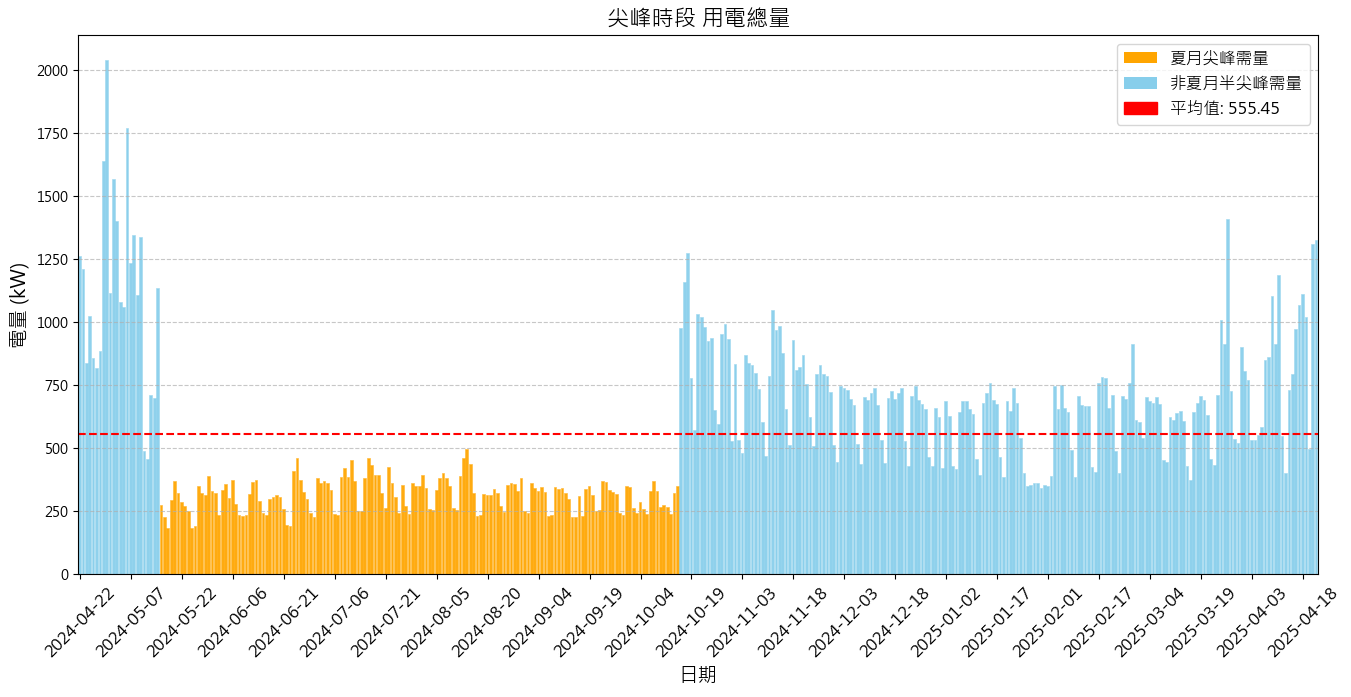

In [236]:
def in_peak_hour(date, elec_type_dict):
    """
    判斷是否在尖峰時段的函數
    :param date: 日期
    :param time: 時間
    :param elec_type_dict: 尖峰時段字典
    :return: 是否在尖峰時段
    """
    result = False
    peak_hour = []
    if ec_config.is_summer(date):
        peak_hour = elec_type_dict.get(ec_config.SeasonType.SUMMER).get(
            ec_config.UsageType.PEAK)
    else:
        elec_hour_dict = elec_type_dict.get(ec_config.SeasonType.NONSUMMER)
        if ec_config.UsageType.PEAK in elec_hour_dict:
            peak_hour = elec_hour_dict.get(ec_config.UsageType.PEAK)
        else:
            peak_hour = elec_hour_dict.get(ec_config.UsageType.SEMI_PEAK)
    peak_hour = pd.to_datetime(peak_hour, format='%H:%M:%S').time
    date_time = date.time()
    # 判斷時間是否在尖峰時段
    if (len(peak_hour) == 2):
        start_time = peak_hour[0]
        end_time = peak_hour[1]
        if start_time <= date_time <= end_time:
            result = True
    elif (len(peak_hour) == 4):
        start_time = peak_hour[0]
        end_time = peak_hour[1]
        if start_time <= date_time <= end_time:
            result = True
        start_time = peak_hour[2]
        end_time = peak_hour[3]
        if start_time <= date_time <= end_time:
            result = True
    return result


def get_peak_hour_usage(data, time_col, usage_col, elec_type_dict):
    """
    顯示尖峰時段用電總量的函數
    :param data: 數據集
    :param time_col: 時間欄位名稱
    :param usage_col: 用電總量欄位名稱
    """
    # 篩選需要的時間段和欄位
    filtered_data = data[data[time_col].apply(
        lambda x: in_peak_hour(x, elec_type_dict))]
    # 按日期統計用電總量
    return filtered_data.groupby(
        filtered_data[time_col].dt.date)[usage_col].sum()


daily_summary = get_peak_hour_usage(raw_data, time_col, usage_col,
                                    elec_type_dict)
average_power = daily_summary.mean()
# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色
colors = [
    'orange' if (date.month > 5 or (date.month == 5 and date.day >= 16)) and
    (date.month < 10 or (date.month == 10 and date.day <= 15)) else 'skyblue'
    for date in daily_summary.index
]

# 繪製柱狀圖
daily_summary.plot(kind='bar',
                   figsize=(16, 7),
                   color=colors,
                   edgecolor=colors,
                   linewidth=1.2,
                   alpha=0.8)

# 設置平均線
plt.axhline(y=average_power, color='red', linestyle='--')

# 設置 X 軸的顯示間隔
x_labels = daily_summary.index
plt.xticks(range(0, len(x_labels), 15),
           x_labels[::15],
           rotation=45,
           fontsize=12)

# 圖表設置
plt.title('尖峰時段 用電總量', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('電量 (kW)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # 日期旋轉以便於閱讀

legend_elements = [
    Patch(facecolor='orange', label='夏月尖峰需量'),
    Patch(facecolor='skyblue',
          label='非夏月半尖峰需量' if contract_type
          == ec_config.ContractType.HIGH_PRESSURE_THREE_PHASE else '非夏月尖峰需量'),
    Patch(color='red', label=f'平均值: {average_power:.2f}')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.close('all')

In [10]:
date_col = "日期"
hour_col = "小時"
battery_output_power_col = "電池放電功率"
battery_usage_col = "電池使用量"
original_15_max_demand_col = "原始15分鐘尖峰需量"
lower_15_max_demand_col = "調整後15分鐘尖峰需量"

filtered_data[date_col] = filtered_data[time_col].dt.date
filtered_data[hour_col] = filtered_data[time_col].dt.hour
filtered_data[battery_output_power_col] = 0.0

daily_15_demand_reset = filtered_data.groupby([date_col]).apply(
    lambda x: x, include_groups=False).reset_index(drop=True)
daily_15_demand_reset[date_col] = daily_15_demand_reset[time_col].dt.date
daily_15_demand = daily_15_demand_reset.groupby([date_col])

lower_daily_summary = pd.DataFrame(
    columns=[date_col, original_15_max_demand_col, lower_15_max_demand_col])
lower_15_usage = pd.DataFrame(
    columns=[time_col, usage_col, battery_output_power_col])
daily_battery_usage = pd.DataFrame(columns=[date_col, battery_usage_col])
last_index = 0
for (idx, daily_data) in enumerate(daily_15_demand):
    dataframe = daily_data[1]
    current_max_usage = dataframe[usage_col].max()
    current_battery = battery_kWh
    # 弭平高於最低值用電
    min_value = dataframe[usage_col].min()
    for i in range(last_index, last_index + len(dataframe)):
        higher_usage = dataframe.loc[i, usage_col] - min_value
        if higher_usage > 0:
            if higher_usage < current_battery:
                if dataframe.loc[
                        i,
                        battery_output_power_col] + higher_usage * 4 <= battery_kw:
                    dataframe.loc[i, usage_col] = min_value
                    dataframe.loc[i,
                                  battery_output_power_col] += higher_usage * 4
                    current_battery -= higher_usage
                else:
                    output_power = (
                        battery_kw -
                        dataframe.loc[i, battery_output_power_col]) / 4
                    dataframe.loc[i, usage_col] -= output_power
                    dataframe.loc[i, battery_output_power_col] = battery_kw
                    current_battery -= output_power
            else:
                if dataframe.loc[
                        i,
                        battery_output_power_col] + current_battery * 4 <= battery_kw:
                    dataframe.loc[i, usage_col] -= current_battery
                    dataframe.loc[
                        i, battery_output_power_col] += current_battery * 4
                    current_battery = 0
                else:
                    output_power = (
                        battery_kw -
                        dataframe.loc[i, battery_output_power_col]) / 4
                    dataframe.loc[i, usage_col] -= output_power
                    dataframe.loc[i, battery_output_power_col] = battery_kw
                    current_battery -= output_power
    # 均勻降低電量
    if current_battery > 0:
        distribute_battery = current_battery / len(
            dataframe[battery_output_power_col] < battery_kw)
        for i in range(last_index, last_index + len(dataframe)):
            if dataframe.loc[
                    i,
                    battery_output_power_col] + distribute_battery * 4 < battery_kw and dataframe.loc[
                        i, usage_col] > distribute_battery:
                dataframe.loc[i, usage_col] -= distribute_battery
                dataframe.loc[
                    i, battery_output_power_col] += distribute_battery * 4
                current_battery -= distribute_battery
            elif dataframe.loc[
                    i,
                    battery_output_power_col] + distribute_battery * 4 < battery_kw and dataframe.loc[
                        i, usage_col] <= distribute_battery:
                current_battery -= dataframe.loc[i, usage_col]
                dataframe.loc[i, battery_output_power_col] += dataframe.loc[
                    i, usage_col] * 4
                dataframe.loc[i, usage_col] = 0
            elif dataframe.loc[
                    i,
                    battery_output_power_col] + distribute_battery * 4 >= battery_kw:
                output_power = (battery_kw -
                                dataframe.loc[i, battery_output_power_col]) / 4
                dataframe.loc[i, usage_col] -= output_power
                dataframe.loc[i, battery_output_power_col] = battery_kw
                current_battery -= output_power
    for i in range(last_index, last_index + len(dataframe)):
        lower_15_usage.loc[len(lower_15_usage)] = [
            dataframe[time_col].loc[i], dataframe[usage_col].loc[i],
            dataframe[battery_output_power_col].loc[i]
        ]
    last_index += len(dataframe)
    daily_battery_usage.loc[idx] = [
        dataframe[date_col].iloc[0],
        dataframe[battery_output_power_col].sum() * 0.25
    ]
    lower_daily_summary.loc[idx] = [
        dataframe[date_col].iloc[0], current_max_usage * 4,
        dataframe[usage_col].max() * 4
    ]

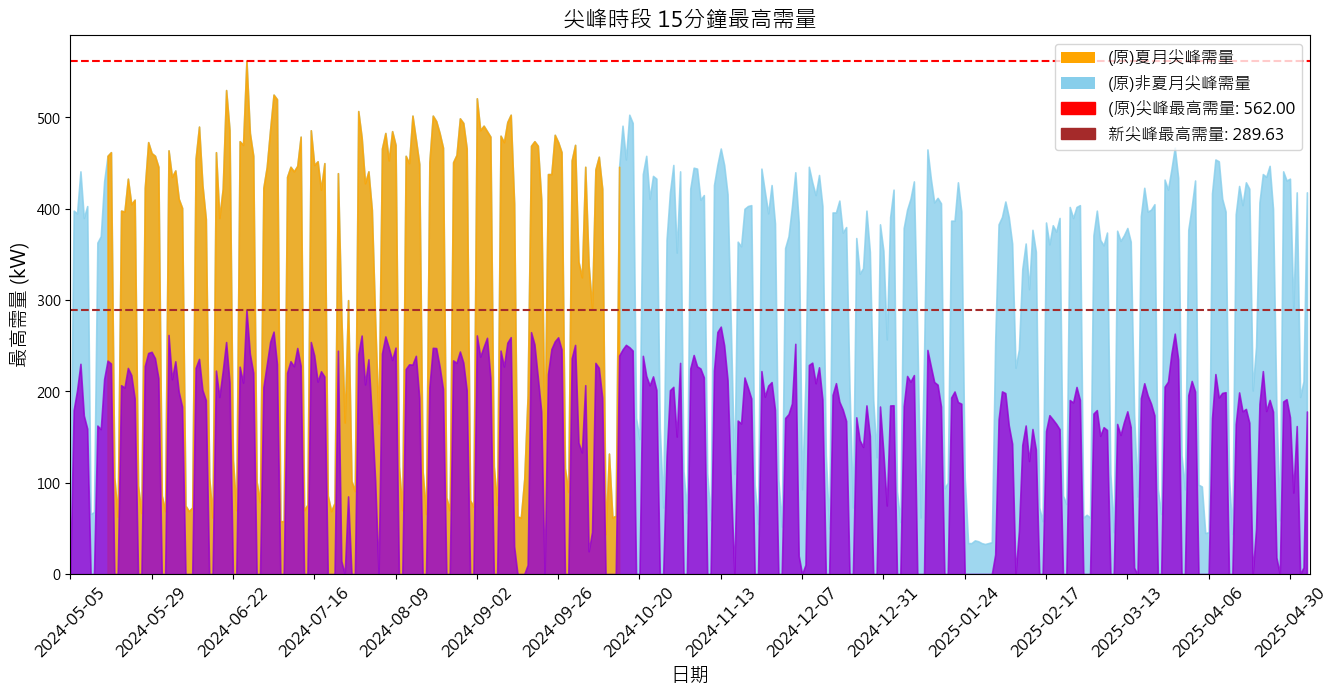

In [12]:
# 按日期統計用電總量
original_max_demand_power = lower_daily_summary[
    original_15_max_demand_col].max()
new_max_demand_power = lower_daily_summary[lower_15_max_demand_col].max()

# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色

new_colors = [
    'lawngreen' if (date.month > 5 or (date.month == 5 and date.day >= 16)) and
    (date.month < 10 or (date.month == 10 and date.day <= 15)) else 'violet'
    for date in lower_daily_summary[date_col]
]
fig, ax = plt.subplots(figsize=(16, 7))

summer_start_index, summer_end_index = 0, 0
for i in range(len(lower_daily_summary[date_col])):
    date = lower_daily_summary[date_col][i]
    if date.month == 5 and date.day == 16:
        summer_start_index = i
    elif date.month == 10 and date.day == 15:
        summer_end_index = i

ax.fill_between(range(len(lower_daily_summary[date_col])),
                lower_daily_summary[original_15_max_demand_col].values,
                label="Daily Summary",
                color='skyblue',
                linewidth=1.2,
                alpha=0.8)
ax.fill_between(range(summer_start_index, summer_end_index),
                lower_daily_summary[original_15_max_demand_col].
                values[summer_start_index:summer_end_index],
                label="Daily Summary",
                color='orange',
                linewidth=1.2,
                alpha=0.8)

# 繪製第二個 DataFrame 的折線圖
ax.fill_between(range(len(lower_daily_summary[date_col])),
                lower_daily_summary[lower_15_max_demand_col].values,
                label="Lower Daily Summary",
                color='darkviolet',
                linewidth=1.2,
                alpha=0.8)

# 設置平均線
ax.axhline(y=original_max_demand_power, color='red', linestyle='--')
ax.axhline(y=new_max_demand_power, color='brown', linestyle='--')

# 設置 X 軸的顯示間隔
x_labels = lower_daily_summary[date_col]
tick_positions = range(0, len(x_labels), max(1, len(x_labels) // 15))  # 設置動態間隔
ax.set_xticks(tick_positions)
ax.set_xticklabels(x_labels[tick_positions], rotation=45, fontsize=12)
ax.set_xlim(left=0, right=len(x_labels))  # X 軸從 0 開始
ax.set_ylim(bottom=0)

# 圖表設置
plt.title('尖峰時段 15分鐘最高需量', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('最高需量 (kW)', fontsize=14)

legend_elements = [
    Patch(facecolor='orange', label='(原)夏月尖峰需量'),
    Patch(facecolor='skyblue', label='(原)非夏月尖峰需量'),
    Patch(color='red', label=f'(原)尖峰最高需量: {original_max_demand_power:.2f}'),
    Patch(color='brown', label=f'新尖峰最高需量: {new_max_demand_power:.2f}')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')
plt.show()

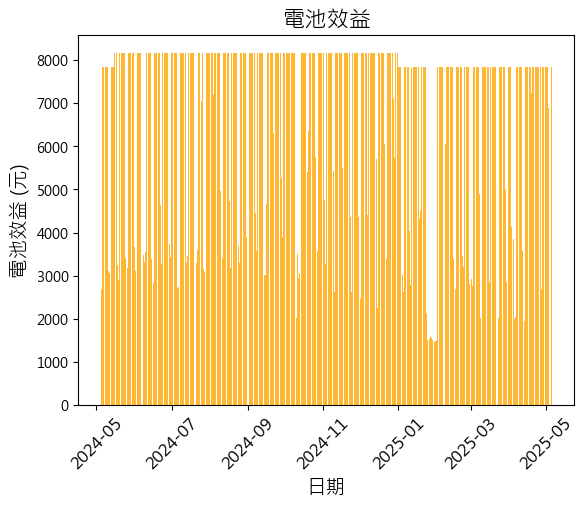

2467616.337


In [30]:
daily_battery_effect_col='每日電池效益'
def get_battery_effect(date):
    summer_price_diff = 11.44-3.2
    nonsummer_price_diff = 10.8-2.89
    if date.month > 5 or (date.month == 5 and date.day >= 16) and \
       date.month < 10 or (date.month == 10 and date.day <= 15):
        return summer_price_diff 
    else:
        return nonsummer_price_diff 

daily_battery_usage[daily_battery_effect_col]= daily_battery_usage.apply(lambda row: row[battery_usage_col] * get_battery_effect(row[date_col]), axis=1)
daily_battery_usage[date_col] = pd.to_datetime(daily_battery_usage[date_col])

plt.bar(daily_battery_usage[date_col],
         daily_battery_usage[daily_battery_effect_col],
         color='orange',
         alpha=0.8)
plt.title('電池效益', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('電池效益 (元)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)


# 設置 X 軸的顯示間隔
x_labels = daily_battery_usage[date_col]
tick_positions = range(0, len(x_labels), max(1, len(x_labels) // 15))  # 設置動態間隔

plt.ylim(bottom=0)
plt.show()
print(daily_battery_usage[daily_battery_effect_col].sum())

In [ ]:
# 原始用電情境
original_usage_data = raw_data.copy()
original_usage_data[columns_to_sum] = raw_data[columns_to_sum] * 0.25
original_usage_data[usage_col] = original_usage_data[columns_to_sum].apply(
    lambda row: row.dropna().unique()[0]
    if row.nunique() == 1 else row.mode().iloc[0],
    axis=1)
original_usage_data = original_usage_data.drop(columns=columns_to_sum)
print(original_usage_data)
original_usage_data[date_col] = original_usage_data[time_col].dt.date
original_usage_data[hour_col] = original_usage_data[time_col].dt.hour

# 計算每月電費
# TODO add calculate function

# 更改後用電情境
lower_usage_data = original_usage_data.copy()
updated_df = lower_usage_data.merge(lower_15_usage,
                                    on=time_col,
                                    how='left',
                                    suffixes=('', '_update'))
updated_df[usage_col] = updated_df[usage_col + '_update'].combine_first(
    updated_df[usage_col])
updated_df = updated_df.drop(columns=[usage_col + '_update'])
